# Generating Faces Using Encoder - Decoders

In [ ]:
import os
import pdb
import sys
import time
import torch
import numpy as np
from PIL import Image
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torchvision import transforms, utils
import torchvision.models as models
from collections import OrderedDict
from torch.utils.data import Dataset,DataLoader

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

In [ ]:
d = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device is : ",d)

Device is :  cuda:0


In [ ]:
random_seeds = 1
learning_rate = 0.001
num_epochs = 20
train_batch_size = 2
test_batch_size = 1

In [ ]:
class Facedata(Dataset):
    
    def __init__(self, root_dir, transform=None):
       
        self.root_dir = root_dir
        self.image_list = [f for f in os.listdir(root_dir) if (f.endswith('.png') or f.endswith('.jpg'))]
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_list[idx])
        image = Image.open(img_name)
        image = image.convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image

In [ ]:
train_data_dir = './StyleGAN/generated_images/data/train'
test_data_dir = './StyleGAN/generated_images/data/test'

face_data_train = Facedata(train_data_dir, transform = transforms.ToTensor())
face_data_test = Facedata(test_data_dir, transform = transforms.ToTensor())

train_dataloader = torch.utils.data.DataLoader(face_data_train, batch_size = train_batch_size, shuffle = True)
test_dataloader = torch.utils.data.DataLoader(face_data_test, batch_size = test_batch_size, shuffle = False)

In [ ]:
print(len(train_dataloader))
print(len(test_dataloader))

100
10


### SegNet Encoder

In [ ]:
class SegNet(nn.Module):
    
    def __init__(self):
        super(SegNet, self).__init__()
        
        self.conv1_1 = nn.Conv2d(1, 64, kernel_size = 3, stride = 1, padding = 1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size = 3, stride = 1, padding = 1)
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size = 3, stride = 1, padding = 1)
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size = 3, stride = 1, padding = 1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size = 3, stride = 1, padding = 1)
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size = 3, stride = 1, padding = 1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size = 3, stride = 1, padding = 1)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size = 3, stride = 1, padding = 1)
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size = 3, stride = 1, padding = 1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size = 3, stride = 1, padding = 1)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size = 3, stride = 1, padding = 1)

        self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0, return_indices = True)
        self.pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0, return_indices = True)
        self.pool3 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0, return_indices = True)
        self.pool4 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0, return_indices = True)
        self.pool5 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0, return_indices = True)
        
        self.unpool5 = nn.MaxUnpool2d(kernel_size = 2, stride = 2, padding = 0)
        self.unpool4 = nn.MaxUnpool2d(kernel_size = 2, stride = 2, padding = 0)
        self.unpool3 = nn.MaxUnpool2d(kernel_size = 2, stride = 2, padding = 0)
        self.unpool2 = nn.MaxUnpool2d(kernel_size = 2, stride = 2, padding = 0)
        self.unpool1 = nn.MaxUnpool2d(kernel_size = 2, stride = 2, padding = 0)

        self.deconv5_1 = nn.ConvTranspose2d(512, 512, kernel_size = 3, stride = 1, padding = 1)
        self.deconv5_2 = nn.ConvTranspose2d(512, 512, kernel_size = 3, stride = 1, padding = 1)
        self.deconv5_3 = nn.ConvTranspose2d(512, 512, kernel_size = 3, stride = 1, padding = 1)
        self.deconv4_1 = nn.ConvTranspose2d(512, 512, kernel_size = 3, stride = 1, padding = 1)
        self.deconv4_2 = nn.ConvTranspose2d(512, 512, kernel_size = 3, stride = 1, padding = 1)
        self.deconv4_3 = nn.ConvTranspose2d(512, 256, kernel_size = 3, stride = 1, padding = 1)
        self.deconv3_1 = nn.ConvTranspose2d(256, 256, kernel_size = 3, stride = 1, padding = 1)
        self.deconv3_2 = nn.ConvTranspose2d(256, 256, kernel_size = 3, stride = 1, padding = 1)
        self.deconv3_3 = nn.ConvTranspose2d(256, 128, kernel_size = 3, stride = 1, padding = 1)
        self.deconv2_1 = nn.ConvTranspose2d(128, 128, kernel_size = 3, stride = 1, padding = 1)
        self.deconv2_2 = nn.ConvTranspose2d(128, 64, kernel_size = 3, stride = 1, padding = 1)
        self.deconv1_1 = nn.ConvTranspose2d(64, 64, kernel_size = 3, stride = 1, padding = 1)
        self.deconv1_2 = nn.ConvTranspose2d(64, 2, kernel_size = 3, stride = 1, padding = 1)

        self.batch_norm1 = nn.BatchNorm2d(64)
        self.batch_norm2 = nn.BatchNorm2d(128)
        self.batch_norm3 = nn.BatchNorm2d(256)
        self.batch_norm4 = nn.BatchNorm2d(512)
    
    def forward(self, x):
        
        size_1 = x.size()
        x = self.conv1_1(x)
        x = self.batch_norm1(x)
        x = F.relu(x)
        x = self.conv1_2(x)
        x = self.batch_norm1(x)
        x = F.relu(x)
        x, idxs1 = self.pool1(x)
        
        size_2 = x.size()
        x = self.conv2_1(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        x = self.conv2_2(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        x, idxs2 = self.pool2(x)
        
        size_3 = x.size()
        x = self.conv3_1(x)
        x = self.batch_norm3(x)
        x = F.relu(x)
        x = self.conv3_2(x)
        x = self.batch_norm3(x)
        x = F.relu(x)
        x = self.conv3_3(x)
        x = self.batch_norm3(x)
        x = F.relu(x)
        x, idxs3 = self.pool3(x)
        
        size_4 = x.size()
        x = self.conv4_1(x)
        x = self.batch_norm4(x)
        x = F.relu(x)
        x = self.conv4_2(x)
        x = self.batch_norm4(x)
        x = F.relu(x)
        x = self.conv4_3(x)
        x = self.batch_norm4(x)
        x = F.relu(x)
        x, idxs4 = self.pool4(x)
        
        size_5 = x.size()
        x = self.conv5_1(x)
        x = self.batch_norm4(x)
        x = F.relu(x)
        x = self.conv5_2(x)
        x = self.batch_norm4(x)
        x = F.relu(x)
        x = self.conv5_3(x)
        x = self.batch_norm4(x)
        x = F.relu(x)
        x, idxs5 = self.pool5(x)

        
        x = self.unpool5(x, idxs5, output_size = size_5)
        x = self.deconv5_1(x)
        x = self.batch_norm4(x)
        x = F.relu(x)
        x = self.deconv5_2(x)
        x = self.batch_norm4(x)
        x = F.relu(x)
        x = self.deconv5_3(x)
        x = self.batch_norm4(x)
        x = F.relu(x)
        
        x = self.unpool4(x, idxs4, output_size = size_4)
        x = self.deconv4_1(x)
        x = self.batch_norm4(x)
        x = F.relu(x)
        x = self.deconv4_2(x)
        x = self.batch_norm4(x)
        x = F.relu(x)
        x = self.deconv4_3(x)
        x = self.batch_norm3(x)
        x = F.relu(x)
        
        x = self.unpool3(x, idxs3, output_size = size_3)
        x = self.deconv3_1(x)
        x = self.batch_norm3(x)
        x = F.relu(x)
        x = self.deconv3_2(x)
        x = self.batch_norm3(x)
        x = F.relu(x)
        x = self.deconv3_3(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        
        x = self.unpool2(x, idxs2, output_size = size_2)
        x = self.deconv2_1(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        x = self.deconv2_2(x)
        x = self.batch_norm1(x)
        x = F.relu(x)
        
        x = self.unpool1(x, idxs1, output_size = size_1)
        x = self.deconv1_1(x)
        x = self.batch_norm1(x)
        x = F.relu(x)
        x = self.deconv1_2(x)
        
        return x

## VGG Encoder Decoder

### Encoder

In [ ]:
class Encoder(torch.nn.Module):

    def __init__(self):
        super(Encoder , self).__init__()
        
        # Encoder layers
        
        self.encoder = nn.Sequential(
            
            # conv1
            
            nn.Conv2d(3, 64, 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride = 2, return_indices = True),
            
            # conv2
            
            nn.Conv2d(64, 128, 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride = 2, return_indices = True),
            
            # conv3
            
            nn.Conv2d(128, 256, 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride = 2, return_indices = True),
            
            # conv4
            
            nn.Conv2d(256, 512, 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride = 2, return_indices = True),
            
            # conv5
            
            nn.Conv2d(512, 512, 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride = 2, return_indices = True)
        )
        
        self.encoder_feature_outputs = OrderedDict()  # store all (conv) feature maps

        self.encoder_pool_indices = OrderedDict() # store all max locations for pooling layers

        # index of convolutional layers
        self.conv_layer_indices = [0, 2, 5, 7, 10, 12, 14, 17, 19, 21, 24, 26, 28]

        #self.init_weights() # initialize weights

    # initialize weights using pre-trained vgg16 on ImageNet
    def init_weights(self):
        vgg16_pretrained = models.vgg16(pretrained = True)
        for idx, layer in enumerate(vgg16_pretrained.features): # feature component
            if isinstance(layer, nn.Conv2d):
                self.encoder[idx].weight.data = layer.weight.data
                self.encoder[idx].bias.data = layer.bias.data
                
    def forward_features(self, x):
        output = x
        for idx, layer in enumerate(self.encoder):
            if isinstance(layer, torch.nn.MaxPool2d):
                output, indices = layer(output)
                # print(layer,output.shape)
                self.encoder_feature_outputs[idx] = output
                self.encoder_pool_indices[idx] = indices
            else:
                output = layer(output)
                # print(layer,output.shape)
                self.encoder_feature_outputs[idx] = output
        return idx, output
    
    def forward(self, x):
        # print('Encoder activations: ')
        idx, output = self.forward_features(x)
        # print('Value of idx in encoder is:',idx)
        latents = output
        
        return idx, int(latents), self.encoder_feature_outputs, self.encoder_pool_indices 

### Decoder

In [ ]:
class Decoder(nn.Module):

    def __init__(self):
        super(Decoder, self).__init__()

        self.decoder = nn.Sequential(
            
            # deconv1
            
            nn.MaxUnpool2d(2, stride = 2),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 512, 3, padding = 1),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 512, 3, padding = 1),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 512, 3, padding = 1),
            
            # deconv2
            
            nn.MaxUnpool2d(2, stride = 2),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 512, 3, padding = 1),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 512, 3, padding = 1),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, 3, padding = 1),
            
            # deconv3
            
            nn.MaxUnpool2d(2, stride = 2),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 256, 3, padding = 1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 256, 3, padding = 1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 3, padding = 1),
            
            # deconv4
            
            nn.MaxUnpool2d(2, stride = 2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 128, 3, padding = 1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 3, padding = 1),
            
            # deconv5
            
            nn.MaxUnpool2d(2, stride = 2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, 3, padding = 1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 3, padding = 1)
        )

        # forward idx : backward idx
        self.conv2deconv_indices = {0:30, 2:28, 5:25, 7:23, 10:20, 12:18, 14:16, 17:13, 19:11, 21:9, 24:6, 26:4,
                                    28:2}
        
        # forward idx : backward idx; not align
        self.conv2deconv_bias_indices = {0:28, 2:25, 5:23, 7:20, 10:18, 12:16, 14:13, 17:11, 19:9, 21:6, 24:4,
                                         26:2}
        
        # forwardidx : backward idx
        self.relu2relu_indices = {1:29, 3:27, 6:24, 8:22, 11:19, 13:17, 15:15, 18:12, 20:10, 22:8, 25:5, 27:3,
                                  29:1}
        
        # backward idx : forward idx
        self.unpool2pool_index = {26:4, 21:9, 14:16, 7:23, 0:30}
        self.unpool2pool_indices = {30:0, 23:7, 16:14, 9:21, 4:26}
        
        self.decoder_feature_outputs = OrderedDict()  # store all (conv) feature maps


        #self.init_weights()  # initialize weights

    # initialize weights using pre-trained vgg16 on ImageNet
    def init_weights(self):
        vgg16_pretrained = models.vgg16(pretrained = True)
        for idx, layer in enumerate(vgg16_pretrained.features): # feature component
            if isinstance(layer, nn.Conv2d):
                self.decoder[self.conv2deconv_indices[idx]].weight.data = layer.weight.data
                if idx in self.conv2deconv_bias_indices:    # bias in first backward layer is randomly set
                    self.decoder[self.conv2deconv_bias_indices[idx]].bias.data = layer.bias.data

    def forward(self, x, layer, activation_idx, pool_locs):
        # print('Layer in decoder is: ',layer)
        # print('decoder activations')
        if layer in self.conv2deconv_indices:
            start_idx = self.conv2deconv_indices[layer]
        elif layer in self.relu2relu_indices:
            start_idx = self.relu2relu_indices[layer]
        elif layer in self.unpool2pool_indices:
            # print('true unpool2pool')
            # print('No such Conv2d or RelU layer!')
            start_idx = self.unpool2pool_indices[layer]
            # exit()
            # sys.exit(0)
            
        
#         print('start idx is :',start_idx)
#         print('len is: ',len(self.decoder))
        for idx in range(start_idx, len(self.decoder)):
#             print(idx)
#             print(self.unpool2pool_index[idx])
            
            if isinstance(self.decoder[idx], nn.MaxUnpool2d):
                # print('Pool location is: ',pool_locs[self.unpool2pool_index[idx]].shape)
                x = self.decoder[idx](x, pool_locs[self.unpool2pool_index[idx]])
                # print(self.decoder[idx],x.shape)
                self.decoder_feature_outputs[idx] = x
            else:
                x = self.decoder[idx](x)
                # print(self.decoder[idx],x.shape)
                self.decoder_feature_outputs[idx] = x

        reconstructed = x

        return reconstructed, self.decoder_feature_outputs

In [ ]:
encoder = Encoder()
decoder = Decoder()

encoder = encoder.to(d)
decoder = decoder.to(d)

print("---"*35)
print('                                          ENCODER                                                        ')
print("---"*35)
print(encoder)
print("---"*35)
print('                                          DECODER                                                        ')
print("---"*35)
print(decoder)

---------------------------------------------------------------------------------------------------------
                                          ENCODER                                                        
---------------------------------------------------------------------------------------------------------
Encoder(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(25

In [ ]:
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()),weight_decay=1e-5)
print(np.shape(list(encoder.parameters()) + list(decoder.parameters())))

(52,)


In [ ]:
criterion = nn.MSELoss()

In [ ]:
print("---"*35)
print('                                       ENCODER PARAMETERS                                               ')
print("---"*35)
for i in range(len(list(encoder.parameters()))):
    print(list(encoder.parameters())[i].shape)
print()
print("---"*35)
print('                                       DECODER PARAMETERS                                               ')
print("---"*35)
for i in range(len(list(decoder.parameters()))):
    print(list(decoder.parameters())[i].shape)

---------------------------------------------------------------------------------------------------------
                                       ENCODER PARAMETERS                                               
---------------------------------------------------------------------------------------------------------
torch.Size([64, 3, 3, 3])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([128, 64, 3, 3])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([256, 128, 3, 3])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([512, 256, 3, 3])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])

-------------------------------------------------------------------------------

In [ ]:
print(optimizer)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 1e-05
)


In [ ]:
print(criterion)

MSELoss()


In [ ]:
start_time = time.time()
train_loss = []
for epoch in range(num_epochs):
    for batch_idx, original_images in enumerate(train_dataloader):
        
        # print(original_images.shape)
        original_images = original_images.to(d)
        
        optimizer.zero_grad() # clear accumulated gradients

        # FORWARD AND BACK PROP
        
        final_layer_index,encoded_latents,encoder_feature_maps,encoder_pooling_indices = encoder(original_images)
        # print("Encoded latents shape :", encoded_latents.shape)
        reconstructed_images, decoder_feature_maps = decoder(encoded_latents, final_layer_index,encoder_feature_maps, encoder_pooling_indices)
        
        loss = criterion(reconstructed_images, original_images)
        train_loss.append(loss)
        
        loss.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_dataloader)//train_batch_size, loss))
            
    torch.save(encoder.state_dict(), './conv_encoder_{}.pth'.format(epoch))
    torch.save(decoder.state_dict(), './conv_decoder_{}.pth'.format(epoch))        
    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

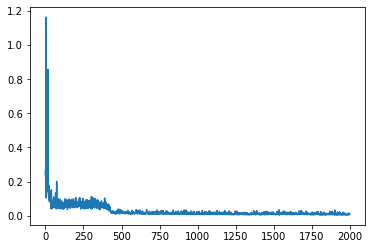

In [ ]:
plt.plot(train_loss)

          ORIGINAL IMAGE


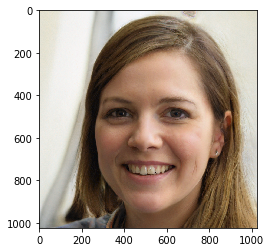

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


        RECONSTRUCTED IMAGE


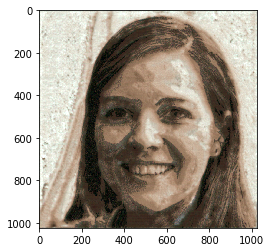

          ORIGINAL IMAGE


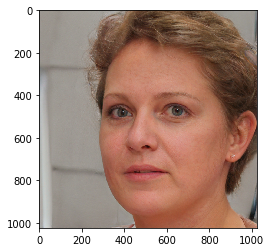

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


        RECONSTRUCTED IMAGE


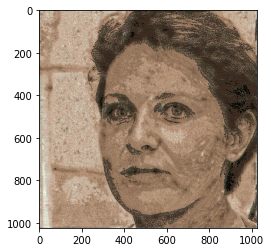

          ORIGINAL IMAGE


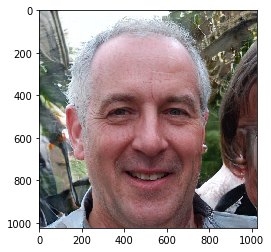

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


        RECONSTRUCTED IMAGE


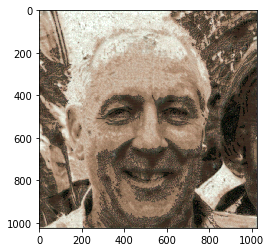

          ORIGINAL IMAGE


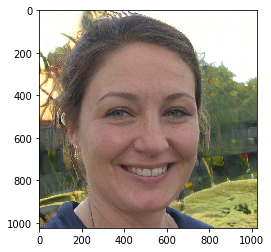

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


        RECONSTRUCTED IMAGE


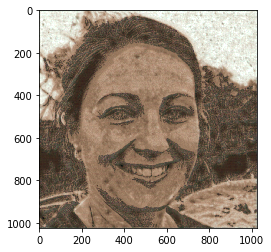

          ORIGINAL IMAGE


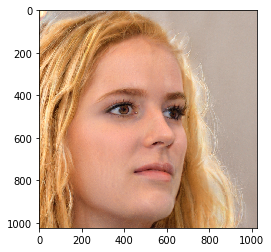

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


        RECONSTRUCTED IMAGE


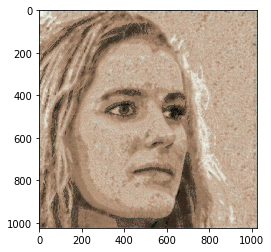

          ORIGINAL IMAGE


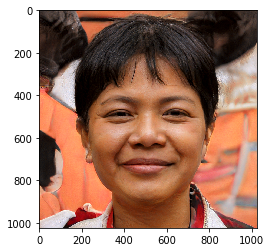

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


        RECONSTRUCTED IMAGE


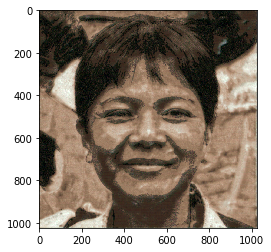

          ORIGINAL IMAGE


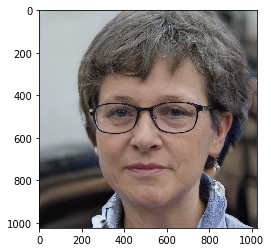

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


        RECONSTRUCTED IMAGE


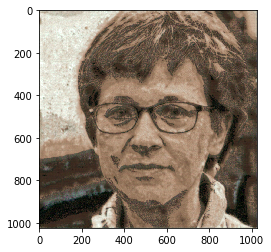

          ORIGINAL IMAGE


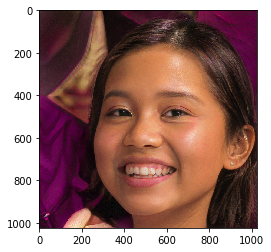

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


        RECONSTRUCTED IMAGE


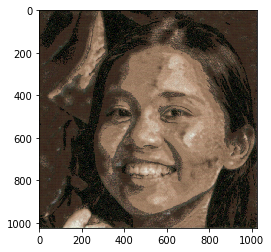

          ORIGINAL IMAGE


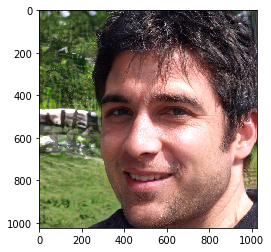

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


        RECONSTRUCTED IMAGE


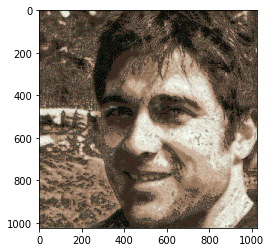

          ORIGINAL IMAGE


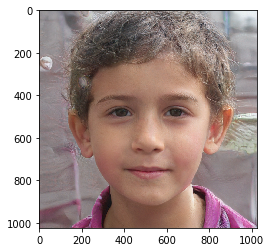

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


        RECONSTRUCTED IMAGE


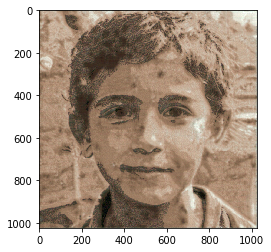

In [ ]:
start_time = time.time()
for batch_indx, original_test_images in enumerate(test_dataloader):
        
  #print(original_test_images.shape)
  orig = original_test_images.cpu().detach().numpy().squeeze()
  original_test_images = original_test_images.to(d)

  # FORWARD PASS
  
  t_final_layer_index,t_encoded_latents,t_encoder_feature_maps, t_encoder_pooling_indices = encoder(original_test_images)
  # print("Encoded latents shape :", encoded_latents.shape)
  t_reconstructed_images, t_decoder_feature_maps = decoder(t_encoded_latents, t_final_layer_index, t_encoder_feature_maps, t_encoder_pooling_indices)

  # print(t_reconstructed_images.shape)
  t_reconstructed = t_reconstructed_images.cpu().detach().numpy().squeeze()
  # print(t_reconstructed.shape)
  t_reconstructed = np.moveaxis(t_reconstructed,0,-1)
  orig = np.moveaxis(orig,0,-1)
  #print(reconstructed)
  print("          ORIGINAL IMAGE")
  #plt.imshow(orig.astype('uint8'))
  plt.imshow(orig)
  plt.show()
  print("        RECONSTRUCTED IMAGE")
  #plt.imshow(t_reconstructed.astype('uint8'))
  plt.imshow(t_reconstructed)
  # plt.savefig('rec_{}.)
  plt.show()